# Brain Tumor Classification Using Fisher Vector as Features Representation and Linear Logistic Regression as Classifier

This work is an implementation and modification of [[1]](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0157112) and [[2]](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0140381) in python code (Python was chosen since we wanted to implement a functional web applciation for radiologist. You can see [my repo](https://github.com/abdulfaqihalm/finalProject) to take a look at the web-app). The modification of [[1]](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0157112) and [[2]](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0140381) is only the classifier. The author of [[1]](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0157112) used metric learning - Mahalanobis distance -  to classify the features representation output from Fisher Vectors. Here, we used a simple linear classifier : multi-class logistic regression from sklearn library yet still with a good result. 

The implementation consists into four steps : 
1. Tumor region augmentation to obatain valuable information about surrounding tissues
2. Subregion local features extraction with spatial division method based on intensity orders
3. Fisher vector implementation to obtain single vector representation of subregion local features
4. Classification process 

We used the dataset from [here](https://figshare.com/articles/brain_tumor_dataset/1512427) in .mat format. You will notice that we also used DICOM dataset which was a converted version from .mat file. The reason of that, we wanted to have the [real-case prototype of clinical diagnosis software](https://github.com/abdulfaqihalm/finalProject). The DICOM dataset version can be downloaded from [here](https://drive.google.com/drive/folders/1xMq05zgyZy3ewrHhwAa5heKsnZy2afXp). 

To summarize, these are links for the dataset and other files which were used for this project : 
1. [Matlab dataset](https://figshare.com/articles/brain_tumor_dataset/1512427) 
2. [DICOM dataset](https://drive.google.com/drive/folders/1xMq05zgyZy3ewrHhwAa5heKsnZy2afXp?usp=sharing)
3. [Index, label, and trained model's parameters](https://drive.google.com/open?id=1ZtBz3OhThMDQ9vKvWtPEmFHEzOdg6Rtm)

In [3]:
import h5py
import pydicom
import os
import numpy as np
from matplotlib import pyplot as plt
import scipy
from skimage.morphology import disk, binary_dilation 
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from cyvlfeat.gmm import gmm
from cyvlfeat.fisher import fisher

In [4]:
#Dictionary size to be used for GMM learning process
dictSize = 64 

#Raw image patches size as local features
patSize = 7 

#Dilation radius of structuring element to augment the tumor region
dilationRad = 2 

#Subregion of intensity based (i.e. for maximum intensity value 80, , it will devide the features
#into several regions. There are : 0-10, 11-20, .. 71-80) 
nRegion = 8 

filePath= <Your .mat path>
dicomPath = <Your DICOM path>

## Image Normalization 
The normalization of dataset uses rescalling method(min-max normalization) to rescale the intensity value of 16 bit MRI T1 images.

## Tumor Patches Extraction 
The local descriptors of the tumor region use raw image patches to be encoded to the higher level features by Fisher Vector. Since the raw patches is simple, yet,  sufficiently efficient for image classification, it can  reduce the complexity of the process of feature extraction and improve computing efficiency.You can read further information about the raw patches local descriptors for Fisher Vector in [this paper](https://www.mdpi.com/2078-2489/9/2/38/htm).

![](img/ImagePatches.JPG)

In [5]:
#Image normalization using 
def norm(image):
    minElm = np.amin(image)
    maxElm = np.amax(image)
    normImage = np.true_divide((np.subtract(image, minElm)), (maxElm - minElm))
    return normImage 

#Tumor region patches for visual words vocabulary 
def extractLocTrainFeas(normImage, dilMask, patSize):
    (r, c) = np.float32(dilMask.nonzero())
    offset = (patSize-1)/2
    x = np.linspace(-offset, offset, patSize, dtype='float32')
    [x, y] = np.meshgrid (x, x)
    rDelta = x 
    cDelta = y
    feas = np.zeros((patSize**2, c.size), dtype='float32')
    n = 0 
    for i in range(patSize):
        for j in range(patSize):
            rShifted = r + rDelta[i, j]
            cShifted = c + cDelta[i, j]      
            feas[n, :] = normImage[rShifted.astype(int), cShifted.astype(int)]
            n += 1 
    len = int((np.size(feas, 1)-1)/5)
    arr = np.random.permutation(np.size(feas, 1))[0:len]
    feas = feas[:, arr]
    return feas

## Loading Label and Index
To train the model, we only used the single validation using index 1. In this work, we converted the index and label to .npz for convenience. You can download the label, index and other model parameters at [this link](https://drive.google.com/open?id=1ZtBz3OhThMDQ9vKvWtPEmFHEzOdg6Rtm). 

In [5]:
## Determining the index for testing and training 
index = np.load('cvIndex.npz')
index = index['cvind']
    
# Index 1 for training and other for testing 
testInd = np.uint16(np.where(index==(1))[1])
trainInd = np.uint16(np.where(index!=(1))[1])

# Loading label 
label = np.load('label.npz')
label = label['label']

trainLabel = label[trainInd]
testLabel = label[testInd]


## Extracting Local Features from Training set
This cell will loop through training set to extract and append the local features. The local features consist of tumor patches of images. The local features matrix size is 49xN where 49 comes from the numbers of patches and N comes from the total tumor pixel of all images which appended. 
To reduce the computation resources, we pick 300000 coloumns randomly.

In [7]:
temp = []
n = 0
for i in trainInd:
    print("{}-th Iteration ".format(n))
    arrays = {}
    arr = {}
    normImage = np.empty([2,2])
    f = h5py.File(os.path.join(filePath,str(i+1)+".mat"),'a')
    for k, v in f.items() : 
        arrays[k] = np.array(v)
        for i, j in v.items() : 
            arr[i] = np.array(j, dtype=np.float32)
    image = arr['image']
    mask = arr['tumorMask']
    normImage = norm(image)
    normImage = np.fliplr(np.rot90(normImage,1,(1,0)))
    mask = np.fliplr(np.rot90(mask,1,(1,0)))
    se = disk(dilationRad)
    dilMask = binary_dilation(mask, se)
    feas = extractLocTrainFeas(normImage, dilMask, patSize)
    temp.append(feas)
    n = n+1

cluFeas = np.empty([49, 0], dtype='float32')
for i in range (trainInd.shape[0]):
    x = np.array(temp[i])
    cluFeas = np.append(cluFeas, x, axis=1)
print(cluFeas.shape)

#Intended to reduce the computation complexity. Therefore, we needed just 300000 features from extracted local features.
#You can change the value if you want to expand or reduce the features
arr = np.random.permutation(np.size(cluFeas, 1))[0:300000]
cluFeas = cluFeas[:, arr]
print(cluFeas.shape)

(49, 2478945)
(49, 300000)


## Features Reduction 
To reduce the computation, we also reduced the dimension of features using PCA. Here, we only considered the number of features dimension from the 99% cumulative percentage of its eigenvalue. 

We can reduce to 8-th first features.


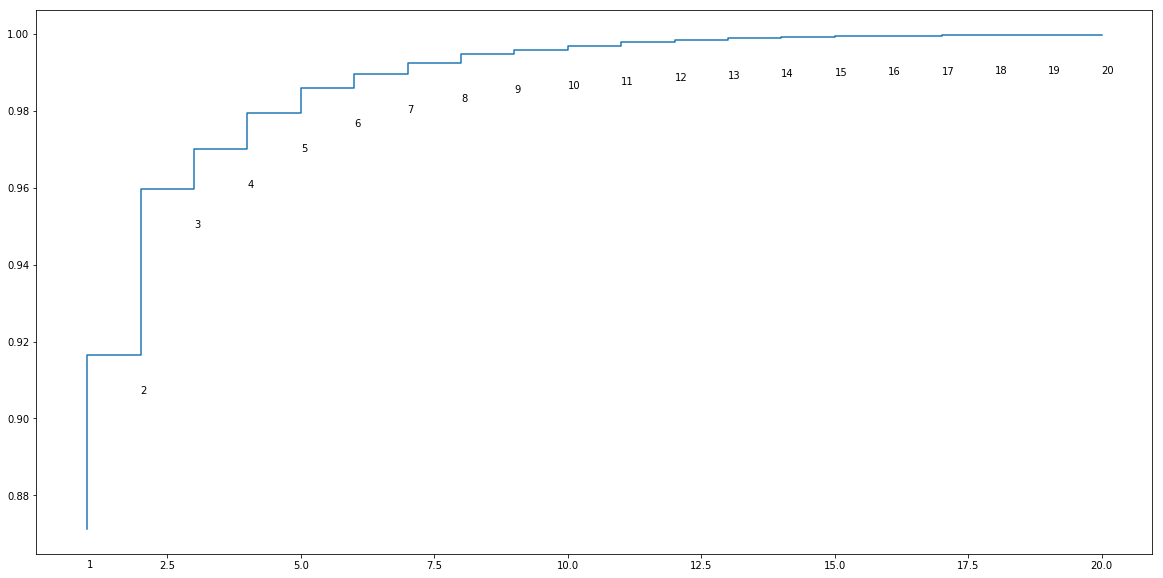

In [9]:
# Validating how many components must be included
pca = PCA(svd_solver='full') 
# Transpose to make the dense patches as a measurement variables
pca.fit(cluFeas.transpose())

x = np.arange(1, 21)
y = np.cumsum(pca.explained_variance_ratio_[:20])

# Finding the index of cumulative percentage of eigenvalue where the cum > 99%
compIndex = np.where(np.cumsum(pca.explained_variance_ratio_[:20])>0.99)[0][0]
print("We can reduce to {}-th first features.".format(compIndex+1))

# Plotting the eigenValue cumulative percentage
plt.figure(figsize=(20,10)) 
plt.step(x, y)
for i_x, i_y in zip(x, y):
    plt.text(i_x, i_y-0.01, '{}'.format(i_x))

In [10]:
# Average of each row of cluFeas 
cluFeasAvg = np.mean(cluFeas, 1)

# Transforming the features and truncating
pca = PCA(n_components=(compIndex+1), svd_solver='full')
pca.fit(cluFeas.transpose())
score = pca.fit_transform(cluFeas.transpose())
principalComp = pca.components_
print('Score shape : ')
print(score.shape)
print('\nScore 1st row : ')
print(score[0])
print('\nTruncated Eigenvalue : ')
print(pca.explained_variance_)

# Saving the score and princComp
np.savez_compressed('score.npz', score=score)
np.savez_compressed('principalComp.npz', principalComp=principalComp)

Score shape : 
(300000, 8)

Score 1st row : 
[-0.00544921  0.43438402 -0.316197   -0.10672852 -0.0651527   0.01000253
 -0.05464405  0.02541979]

Truncated Eigenvalue : 
[0.7606879  0.03957978 0.0375922  0.0090944  0.00817247 0.0056915
 0.00314325 0.002553  ]


## Gaussian Mixture Models
To find the Fisher Vectors, we determined the generative model (a GMM) which approximates the distribution of low-level features (visual vocabolaries).

In [11]:
# Finding the Gaussian Mixture Models
# The Outputs type all in as score.dtype
[means, covariances, priors, LL, posteriors] = gmm(score, dictSize, verbose=True, max_num_iterations=500)


vl_gmm: vl_init_mode = rand
vl_gmm: maxNumIterations = 500
vl_gmm: numRepetitions = 1
vl_gmm: data type = float
vl_gmm: data n_features = 8
vl_gmm: num. data points = 300000
vl_gmm: num. Gaussian modes = 64
vl_gmm: lower bound on covariance = [ 0.000100 0.000100 ... 0.000100]
gmm: clustering: starting repetition 1 of 1
gmm: model initialized in 0.15 s
gmm: em: iteration 0: loglikelihood = 1365957.648621 (variation = inf)
gmm: em: iteration 1: loglikelihood = 2214258.944451 (variation = 848301.295830)
gmm: em: iteration 2: loglikelihood = 2383974.995216 (variation = 169716.050765)
gmm: sparsity of data posterior: 85.6%
gmm: em: iteration 3: loglikelihood = 2445316.734580 (variation = 61341.739364)
gmm: sparsity of data posterior: 86.4%
gmm: em: iteration 4: loglikelihood = 2465551.574552 (variation = 20234.839973)
gmm: sparsity of data posterior: 86.7%
gmm: em: iteration 5: loglikelihood = 2475566.065120 (variation = 10014.490568)
gmm: sparsity of data posterior: 86.9%
gmm: em: iteratio

gmm: detected 1 of 64 modes with at least one dimension with covariance too small (set to lower bound)
gmm: em: iteration 55: loglikelihood = 2515775.491758 (variation = 107.208417)
gmm: sparsity of data posterior: 89.9%
gmm: detected 1 of 64 modes with at least one dimension with covariance too small (set to lower bound)
gmm: em: iteration 56: loglikelihood = 2515880.116433 (variation = 104.624675)
gmm: sparsity of data posterior: 89.9%
gmm: detected 1 of 64 modes with at least one dimension with covariance too small (set to lower bound)
gmm: em: iteration 57: loglikelihood = 2515982.123785 (variation = 102.007351)
gmm: sparsity of data posterior: 89.9%
gmm: detected 1 of 64 modes with at least one dimension with covariance too small (set to lower bound)
gmm: em: iteration 58: loglikelihood = 2516079.656820 (variation = 97.533036)
gmm: sparsity of data posterior: 89.9%
gmm: detected 1 of 64 modes with at least one dimension with covariance too small (set to lower bound)
gmm: em: itera

gmm: detected 1 of 64 modes with at least one dimension with covariance too small (set to lower bound)
gmm: em: iteration 100: loglikelihood = 2518231.026368 (variation = 45.933689)
gmm: sparsity of data posterior: 90.2%
gmm: detected 1 of 64 modes with at least one dimension with covariance too small (set to lower bound)
gmm: em: iteration 101: loglikelihood = 2518277.331723 (variation = 46.305354)
gmm: sparsity of data posterior: 90.2%
gmm: detected 1 of 64 modes with at least one dimension with covariance too small (set to lower bound)
gmm: em: iteration 102: loglikelihood = 2518324.051233 (variation = 46.719511)
gmm: sparsity of data posterior: 90.2%
gmm: detected 1 of 64 modes with at least one dimension with covariance too small (set to lower bound)
gmm: em: iteration 103: loglikelihood = 2518370.800876 (variation = 46.749643)
gmm: sparsity of data posterior: 90.2%
gmm: detected 1 of 64 modes with at least one dimension with covariance too small (set to lower bound)
gmm: em: iter

## Subregion extraction 
The reason why we pooled the tumor region into intensity-based is to obtain the both spatial information and intesity distributions. Hence, we could obtain more representative and discriminative features.
You can read more about subregion intensity-based features extraction from [[4]](https://ieeexplore.ieee.org/abstract/document/5995385)

![](img/Subregion.JPG)

In [13]:
# Getting the region index 
def regionInd(normImage, dilMask, nRegion):
    intensities = normImage[dilMask]
    quantiles = np.float32(np.quantile(intensities, np.linspace(0, 1, nRegion+1)))
    regInd = np.zeros(intensities.size)
    for i in range (nRegion):
        ind = np.logical_and((intensities>=quantiles[i]), (intensities<=quantiles[i+1]))
        regInd[ind] = i
    return regInd

# Extract local feas for all images (train and test)
def extractLocFeasAll(normImage, dilMask, patSize):
    (r, c) = np.float32(dilMask.nonzero())
    offset = (patSize-1)/2
    x = np.linspace(-offset, offset, patSize, dtype='float32')
    [x, y] = np.meshgrid (x, x)
    rDelta = x 
    cDelta = y
    feas = np.zeros((patSize**2, c.size), dtype='float32')
    n = 0 
    for i in range(patSize):
        for j in range(patSize):
            rShifted = r + rDelta[i, j]
            cShifted = c + cDelta[i, j]      
            feas[n, :] = normImage[rShifted.astype(int), cShifted.astype(int)]
            n += 1 
    return feas

## Improved Fisher Vector 
According to vlfeaat.org, The Fisher kernel is a powerful framework which combines the strengths of generative and discriminative approaches to pattern classiﬁcation [[5]](https://ieeexplore.ieee.org/document/4270291). The idea is to characterize a signal with a gradient vector derived from a probability density function(pdf) which models the generation process of the signal. For the problem of image categorization the inputs ignals are images and use generative model GMM which approximates the distribution of low-level features in images.
<p>Let \(I = (\bf{x_1},\dots,\bf{x_N})\) be a set of \(D\) dimensional feature vectors extracted from an image. Let \(\Theta=(\mu_k,\Sigma_k,\pi_k:k=1,\dots,K)\) be the parameters of a Gaussian Mixture Model fitting the distribution of descriptors. The GMM associates each vector \(\bf{x_i}\) to a mode \(k\) in the mixture with a strength given by the posterior probability:</p>
<p class="formulaDsp">
\[ q_{ik} = \frac {\exp\left[-\frac{1}{2}(\bf{x_i} - \mu_k)^T \Sigma_k^{-1} (\bf{x_i} - \mu_k)\right]} {\sum_{t=1}^K \exp\left[-\frac{1}{2}(\bf{x_i} - \mu_t)^T \Sigma_k^{-1} (\bf{x_i} - \mu_t)\right]}. \]
</p>
<p>For each mode \(k\), consider the mean and covariance deviation vectors</p>
<p class="formulaDsp">
\begin{align*} u_{jk} = {1 \over {N \sqrt{\pi_k}}} \sum_{i=1}^{N} q_{ik} \frac{x_{ji} - \mu_{jk}}{\sigma_{jk}}, \\ v_{jk} = {1 \over {N \sqrt{2 \pi_k}}} \sum_{i=1}^{N} q_{ik} \left[ \left(\frac{x_{ji} - \mu_{jk}}{\sigma_{jk}}\right)^2 - 1 \right]. \end{align*}
</p>
<p>where \(j=1,2,\dots,D\) spans the vector dimensions. The FV of image \(I\) is the stacking of the vectors \(\bf{u_k}\) and then of the vectors \(\bf{v_k}\) for each of the \(K\) modes in the Gaussian mixtures:</p>
<p class="formulaDsp">
\[ \Phi(I) = \begin{bmatrix} \vdots \\ \bf{u_k} \\ \vdots \\ \bf{v_k} \\ \vdots \end{bmatrix}. \]
</p>


The Improved Fisher Vector [[6]](https://www.robots.ox.ac.uk/~vgg/rg/papers/peronnin_etal_ECCV10.pdf) using the ideas : 
1. Non-linear additive kernel. The Hellinger's kernel (or Bhattacharya coefficient) can be used instead of the linear one at no cost by signed squared rooting. This is obtained by applying the function |z|signz to each dimension of the vector Φ(I). Other additive kernels can also be used at an increased space or time cost.
2. Normalization. Before using the representation in a linear model (e.g. a support vector machine), the vector Φ(I) is further normalized by the l2 norm (note that the standard Fisher vector is normalized by the number of encoded feature vectors).

In [39]:
# If compIndex+1 = 8, so the size of feaMat = 8*2*64*8 x 3064 = 8192 x 3064
feaMat = np.empty(((compIndex+1) * 2 * dictSize * nRegion, 0), dtype='float32')
for i in range(3064):
    temp = []
    arrays = {}
    arr = {}
    normImage = np.empty([2,2])
    image = pydicom.filereader.dcmread(os.path.join(dicomPath,str(i+1)+".dcm")).pixel_array
    f = h5py.File(os.path.join(filePath,str(i+1)+".mat"),'a')
    for k, v in f.items() : 
        arrays[k] = np.array(v)
        for i, j in v.items() : 
            arr[i] = np.array(j, dtype=np.float32)
    mask = arr['tumorMask']
    normImage = norm(image)
    mask = np.fliplr(np.rot90(mask,1,(1,0)))
    se = disk(dilationRad)
    dilMask = binary_dilation(mask, se)
    feas = extractLocFeasAll(normImage, dilMask, patSize)
    feas = np.matmul(principalComp,(feas - cluFeasAvg[:,None]))
    regInd = regionInd(normImage, dilMask, nRegion)
    for j in range(nRegion):
        temp = np.append(temp, fisher(feas[::, regInd==j], means.transpose(), 
                     covariances.transpose(), priors.transpose(),improved=True))
    feaMat = np.append(feaMat, temp[:,np.newaxis], axis=1)
print(feaMat.shape)

(8192, 3064)


In [41]:
trainFeaMat = feaMat[:, trainInd]
testFeaMat = feaMat[:, testInd]

## Classification 
Since the Improved Fisher Vectors are linearly separable, we used logistic regression to classify the test data. 

In [46]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
logreg.fit(trainFeaMat.T, np.ravel(trainLabel))
prediction = logreg.predict(testFeaMat.T)

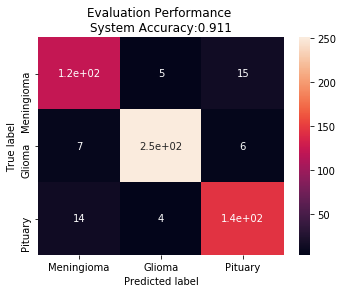

Precision per class : [0.85416667 0.96538462 0.87349398]
Recall per class : [0.86013986 0.95075758 0.88957055]


In [47]:
cm = confusion_matrix(testLabel, prediction)
[prec, recall, fscore, support] = precision_recall_fscore_support(testLabel, prediction)

cm_df = pd.DataFrame(cm,
                     index = ['Meningioma','Glioma','Pituary'], 
                     columns = ['Meningioma','Glioma','Pituary'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Evaluation Performance \nSystem Accuracy:{0:.3f}'.format(accuracy_score(testLabel, prediction)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print('Precision per class : {}'.format(prec))
print('Recall per class : {}'.format(recall))

## References

[1]  [Cheng, Jun, et al. "Retrieval of Brain Tumors by Adaptive Spatial Pooling and Fisher Vector Representation." PloS one 11.6 (2016).](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0157112) 

[2]  [Cheng, Jun, et al. "Enhanced Performance of Brain Tumor Classification via Tumor Region Augmentation and Partition" PloS one 10.8 (2015).](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0140381) 

[3]  [C. Shuangshuang, et al. "Local Patch Vectors Encoded by Fisher Vectors for Image Classification" MDPI 12.22 (2017).](https://www.mdpi.com/2078-2489/9/2/38/htm)

[4]  [B. Fan, et al. "Aggregating gradient distributions into intensity orders: A novel local image descriptor" IEEE (2011)](https://ieeexplore.ieee.org/abstract/document/5995385)

[5]  [P. Florent, D. Christopher. "Fisher Kernels on Visual Vocabularies for Image Categorization" Xerox Research Center (2011)](https://ieeexplore.ieee.org/document/4270291)

[5]  [P. Florent, s. Jorge, M. Thomas. "Improving the fisher kernel for large-scale image classification" ECCV (2010)](https://www.robots.ox.ac.uk/~vgg/rg/papers/peronnin_etal_ECCV10.pdf)